In [ ]:
import pandas as pd
import nltk
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer
import re
import matplotlib.pyplot as plt

# New section

In [ ]:
class Node:
    def __init__(self, index, author, date_published, section, url, headline, description, keywords, second_headline,
                 text):
        self.Index = index
        self.author = author
        self.date_published = date_published
        self.section = section
        self.url = url
        self.headline = headline
        self.description = description
        self.keywords = keywords
        self.second_headline = second_headline
        self.text = text

In [ ]:
def preprocess(text):
    stemmer = PorterStemmer()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    # Lowercase
    text = text.lower()
    # Remove whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords]
    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]
    # Join cleaned tokens
    clean_text = ' '.join(tokens)
    return clean_text

In [ ]:
def compute_text_similarity(text1, text2):
    # Preprocess text
    text1 = preprocess(text1)
    text2 = preprocess(text2)

    # Extract TF-IDF vectors
    vectorizer = TfidfVectorizer()
    vec1 = vectorizer.fit_transform([text1])
    vec2 = vectorizer.transform([text2])

    # Compute cosine similarity
    text_sim = cosine_similarity(vec1, vec2)[0][0]
    return text_sim

In [ ]:
def get_similarity(Node1, Node2):
    text1 = Node1.headline + Node1.description
    text2 = Node2.headline + Node2.description

    # Compute TF-IDF vectors
    vectorizer = TfidfVectorizer()
    vec1 = vectorizer.fit_transform([text1])
    vec2 = vectorizer.transform([text2])

    # Compute cosine similarity
    similarity = cosine_similarity(vec1, vec2)[0][0]

    keywords1 = Node1.keywords.split(',')
    keywords2 = Node2.keywords.split(',')
    common_keywords = len(set(keywords1) & set(keywords2))
    if common_keywords > 0:
        similarity += 0.05 * common_keywords

    final_sim = 0.7 * similarity + 0.3 * compute_text_similarity(Node1.text, Node2.text)

    return final_sim

In [ ]:
def connect_nodes(Nodes):
  similarity_cache = {}
  count=1
  G = nx.Graph()
  for node1 in Nodes:
    for node2 in Nodes:
      if node1 != node2:
        if (node1, node2) in similarity_cache:
          sim = similarity_cache[(node1, node2)]
        else:
          similarity = get_similarity(node1, node2)
          #print(str(count))
          count=count+1
        if similarity >= 0.4:
          #print("edge added number: "+str(count))
          count=count+1
          G.add_edge(node1, node2, attr_dict = {'distance':similarity})

    return G

In [ ]:
def geta_data(name):
    # Use a breakpoint in the code line below to debug your script.
    data1 = pd.read_csv('/input.csv')
    data1 = data1.dropna()
    data1 = data1.drop_duplicates()
    return data1

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data = geta_data("")
Node_list = []
for i in range(0, len(data)):
    temp = Node(data.iloc[i][0], data.iloc[i][1], data.iloc[i][2], data.iloc[i][3], data.iloc[i][4],
                data.iloc[i][5], data.iloc[i][6], data.iloc[i][7], data.iloc[i][8], data.iloc[i][9])
    Node_list.append(temp)

In [ ]:
len(Node_list)

579

In [ ]:
graph = connect_nodes(Node_list)

1
edge added number: 2
3
edge added number: 4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
edge added number: 22
23
24
25
26
27
28
edge added number: 29
30
31
32
33
34
35
36
37
edge added number: 38
39
40
41
42
43
44
edge added number: 45
46
edge added number: 47
48
49
50
51
edge added number: 52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
edge added number: 80
81
82
83
84
85
86
87
88
89
edge added number: 90
91
92
93
edge added number: 94
95
96
edge added number: 97
98
99
100
101
102
edge added number: 103
104
105
edge added number: 106
107
108
109
110
111
112
113
114
115
116
117
118
119
edge added number: 120
121
122
123
124
125
126
127
128
129
130
131
edge added number: 132
133
edge added number: 134
135
136
137
138
139
140
141
edge added number: 142
143
144
145
edge added number: 146
147
edge added number: 148
149
150
151
152
153
154
155
156
157
158
159
edge added number: 160
161
162
163
164
165
edge added number: 166
167
edge added number: 168

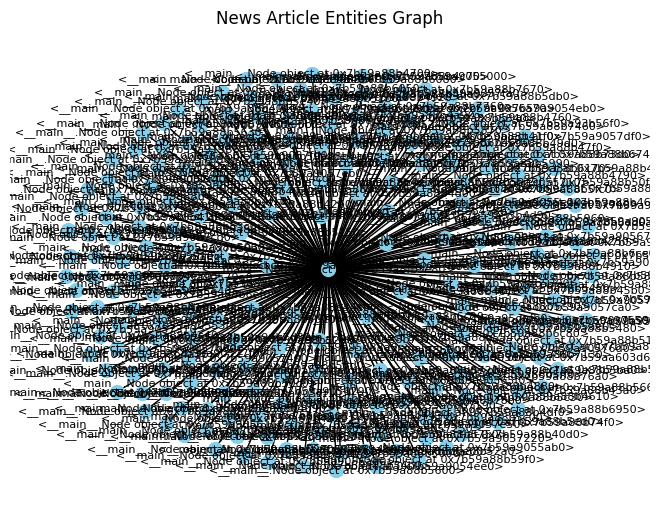

In [ ]:
pos = nx.spring_layout(graph)  # You can use different layout algorithms
labels = {node: node for node in graph.nodes()}
nx.draw(graph, pos, labels=labels, with_labels=True, node_size=100, font_size=8, node_color='skyblue')
plt.title("News Article Entities Graph")
plt.show()

In [ ]:
print(len(graph.edges()))

0


In [ ]:
import networkx as nx
from scipy.cluster.vq import kmeans2

# Algorithm 3: Collapsing nodes

def collapse_nodes(G, theta):

  G_reduced = nx.Graph()
  collapsed_nodes = {}

  for node in G.nodes():
    if G.degree(node) < theta:
      neighbors = list(G.neighbors(node))
      G_reduced.add_edges_from(combinations(neighbors, 2))
      collapsed_nodes[node] = neighbors
      G_reduced.remove_node(node)

  return G_reduced, collapsed_nodes


# Algorithm 4: Graph clustering

def cluster_graph(G_reduced, min_cluster_size):

  clusters = []

  for component in nx.connected_components(G_reduced):
    if len(component) >= min_cluster_size:
      cluster = kmeans2(component, 2)
      clusters.extend(cluster)
    else:
      clusters.append(component)

  return clusters

In [ ]:
def create_supernodes(G, clusters, unchanged_nodes):

  G_supernodes = nx.Graph()

  # Map each cluster to a supernode
  supernodes = {cluster: f"supernode{i}" for i, cluster in enumerate(clusters)}

  # Add supernodes to graph
  for supernode in supernodes.values():
    G_supernodes.add_node(supernode)

  # Add unchanged nodes to corresponding supernode
  for node in unchanged_nodes:
    cluster = clusters[node]
    supernode = supernodes[cluster]
    G_supernodes.add_node(node, supernode=supernode)

  # Add edges between supernodes
  for node1, node2 in G.edges():
    s1 = G_supernodes.nodes[node1]['supernode']
    s2 = G_supernodes.nodes[node2]['supernode']
    if s1 != s2:
      G_supernodes.add_edge(s1, s2)

  return G_supernodes

In [ ]:
# Get unchanged nodes
def get_unchanged_nodes(G_t, G_tminus1, clusters_tminus1):

  unchanged = []

  for node in G_t.nodes():
    if node in G_tminus1:
      # Compare node neighbors
      if set(G_t.neighbors(node)) == set(G_tminus1.neighbors(node)):
        # Node is unchanged
        unchanged.append(node)

  return unchanged


# Map reduced clusters to original graph
def map_to_original(clusters_reduced, G_s, collapsed_nodes):

  clusters = defaultdict(list)

  for cluster in clusters_reduced:

    for node in cluster:
      if node in G_s:
        # Get original node id
        clusters[node].append(node)

      else:
        # Node is from collapsed_nodes
        collapsed = collapsed_nodes[node]
        for n in collapsed:
          clusters[n].append(collapsed)

  return dict(clusters)

In [ ]:
import networkx as nx
from collections import defaultdict

def dpocg(G_t, G_tminus1, clusters_tminus1):
  unchanged = get_unchanged_nodes(G_t, G_tminus1, clusters_tminus1)
  G_s = create_supernodes(G_t, clusters_tminus1, unchanged)
  G_r, collapsed_nodes = collapse_nodes(G_s, theta=2)
  clusters_reduced = cluster_graph(G_r, min_size=3)
  clusters_t = map_to_original(clusters_reduced, G_s, collapsed_nodes)

  return clusters_t


In [ ]:
G_t_minus1 = nx.Graph()
C_t_minus1 = []

for Node in Node_list:
  G_t_minus1.add_node(Node)
  for neighbor_Node in G_t_minus1.nodes():
    similarity = get_similarity(Node, neighbor_Node)
    if similarity >= 0.4:
      G_t_minus1.add_edge(Node, neighbor_Node, attr_dict = {'distance':similarity})


SyntaxError: ignored